In [1]:
from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util, Tvregdiff

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

# import progressbar as pb
import datetime
import os
import sys
import pickle as pkl

# import argparse # add back in once this runs

import matplotlib.pyplot as plt


In [2]:
# load, preprocess example data (same as training, so sue me)
# seed RNG for pytorch/np
SEED = 5050
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# set device - CUDA if you've got it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('mounting to device: {}'.format(device))

# load data
platform_name = sys.platform
if platform_name == 'darwin':
    # local machine
    data_file_full_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
    model_save_dir_path = '/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/'
elif platform_name == 'linux2':
    # HYAK, baby!
    data_file_full_path = '/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
elif platform_name == 'linux':
    # google cloud, don't fail me now
    data_file_full_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.mask.pkl'
    model_save_dir_path = '/home/mickey/models/pyt/seq2seq/'

# make sure the output directory actually exists
if not os.path.exists(model_save_dir_path):
    os.makedirs(model_save_dir_path)

data_in, data_param, data_mask = datareader.load_ecog_clfp_data(data_file_name=data_file_full_path)
srate_in= data_param['srate']
num_ch = data_param['num_ch']
# we already found the appropriate data masks, so just load them in
with open(mask_file_path, 'rb') as f:
    mask_data = pkl.load(f)
hf_mask = mask_data["hf"]
sat_mask = mask_data["sat"]

# mask data array, remove obvious outliers
data_in[:,np.logical_or(hf_mask,sat_mask)] = 0.

# downsample data
srate_down = 250

# create dataset object from file
srate = srate_in
# data_in = np.double(data_in[:,:120*srate])
# enc_len = args.encoder_depth
# dec_len = args.decoder_depth
# seq_len = enc_len+dec_len # use ten time points to predict the next time point

total_len_T = 10*60 # I just don't have that much time!
total_len_n = total_len_T*srate_in
data_idx = data_in.shape[1]//2 + np.arange(total_len_n)
print('Downsampling data from {0} to {1}'.format(srate_in,srate_down))
data_in = np.float32(sp.signal.decimate(data_in[:,data_idx],srate_in//srate_down,axis=-1))
print('Data Size:\t{}'.format(data_in.shape))

# filter dead channels
ch_rms = np.std(data_in,axis=-1)
ch_m = np.mean(ch_rms)
ch_low_lim = ch_m - 2*np.std(ch_rms)
ch_up_lim = ch_m + 2*np.std(ch_rms)
ch_idx = np.logical_and(ch_rms > ch_low_lim, ch_rms < ch_up_lim)
ch_list = np.arange(num_ch)[ch_idx]
num_ch_down = len(ch_list)
print('Num. ch. used:\t{}'.format(num_ch_down))
print('Ch. dropped:\t{}'.format(np.arange(num_ch)[np.logical_not(ch_idx)]))

data_in = data_in[ch_idx,:]

mounting to device: cpu
Loading data file:
Downsampling data from 1000 to 250
Data Size:	(62, 150000)
Num. ch. used:	56
Ch. dropped:	[28 29 58 59 60 61]


/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


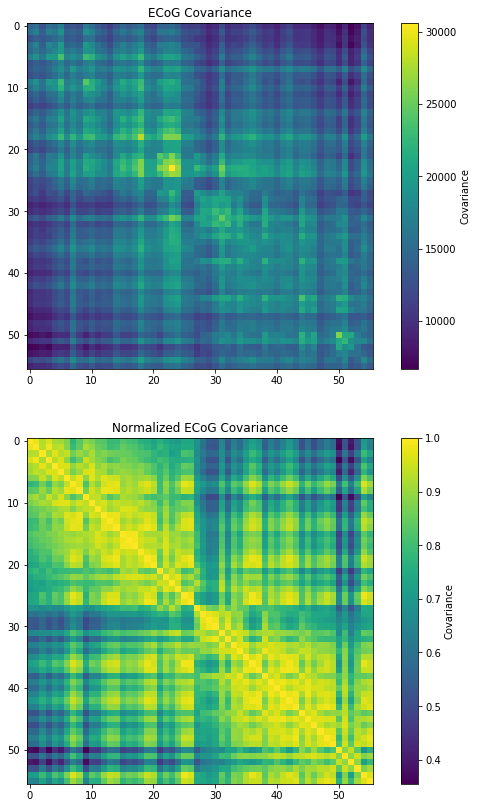

In [3]:
# plot data covariances
n_data = data_in.shape[-1]
data_z = sp.stats.zscore(data_in,axis=-1)
data_cov = np.cov(data_in)
data_z_cov = np.cov(data_z)
# full data covariance
f,ax = plt.subplots(2,1,figsize=(10,14))
plt.colorbar(ax[0].imshow(data_cov),ax=ax[0],label='Covariance')
ax[0].set_title('ECoG Covariance')
plt.colorbar(ax[1].imshow(data_z_cov),ax=ax[1],label='Covariance')
ax[1].set_title('Normalized ECoG Covariance')
f.show()

/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


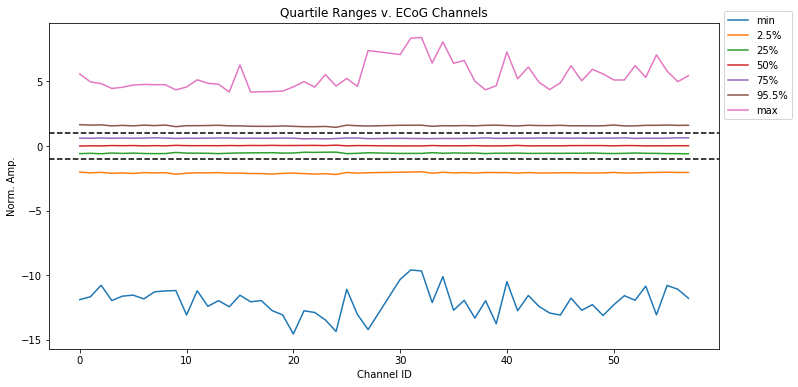

In [4]:
# plot IQR stats for all channels
data_z_iqr = np.percentile(data_z,[0,2.5,25,50,75,95.5,100],axis=-1)
f,ax = plt.subplots(1,1,figsize=(12,6))
ch_q_lines = ax.plot(ch_list,data_z_iqr.T)
ax.legend(ch_q_lines,('min','2.5%','25%','50%','75%','95.5%','max'),bbox_to_anchor=(1.0, 1.05))
ax.axhline(1,color='black',linestyle='--')
ax.axhline(-1,color='black',linestyle='--')
ax.set_xlabel('Channel ID')
ax.set_ylabel('Norm. Amp.')
ax.set_title('Quartile Ranges v. ECoG Channels')
f.show()

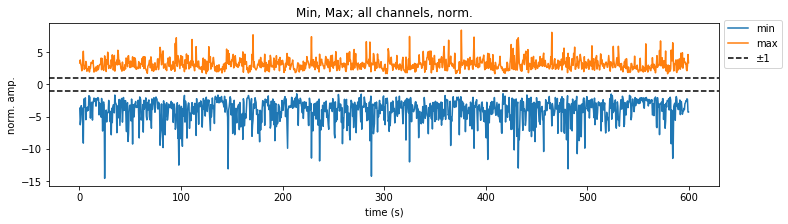

In [5]:
# look @min/max values on 1s windows, 0.5s steps
window_len = 125
step_len = 125
n_window = (n_data-window_len)//step_len
min_max_win = np.zeros((2,n_window))
for w_idx in range(n_window):
    data_idx = w_idx*step_len + np.arange(window_len)
    min_max_win[0,w_idx] = np.min(data_z[:,data_idx].reshape(-1))
    min_max_win[1,w_idx] = np.max(data_z[:,data_idx].reshape(-1))
win_t = 0.5 + np.arange(n_window)/2
f, ax = plt.subplots(1,1,figsize=(12,3))
mmlines = ax.plot(win_t,min_max_win.T)
ax.set_xlabel('time (s)')
ax.set_ylabel('norm. amp.')
ax.set_title('Min, Max; all channels, norm.')
ax.axhline(-1,color='black',linestyle='--')
ax.axhline(1,color='black',linestyle='--')
ax.legend(('min','max','±1'),bbox_to_anchor=(1.0, 1.05))

/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


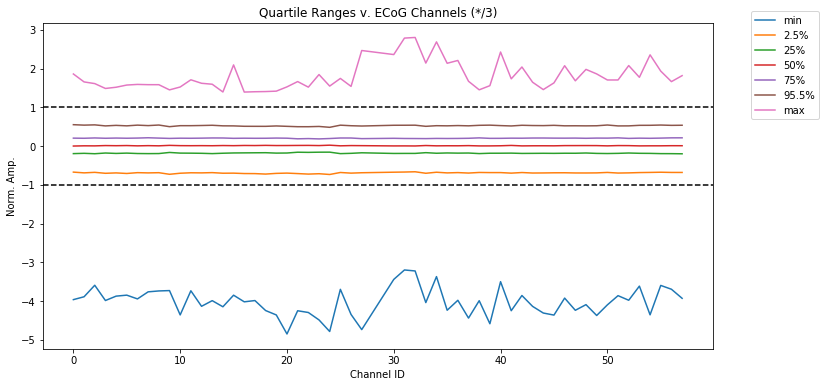

In [6]:
# plot IQR stats for all channels
data_z_iqr = np.percentile(data_z/3,[0,2.5,25,50,75,95.5,100],axis=-1)
f,ax = plt.subplots(1,1,figsize=(12,6))
ch_q_lines = ax.plot(ch_list,data_z_iqr.T)
ax.legend(ch_q_lines,('min','2.5%','25%','50%','75%','95.5%','max'),bbox_to_anchor=(1.05, 1.05))
ax.axhline(1,color='black',linestyle='--')
ax.axhline(-1,color='black',linestyle='--')
ax.set_xlabel('Channel ID')
ax.set_ylabel('Norm. Amp.')
ax.set_title('Quartile Ranges v. ECoG Channels (*/3)')
f.show()

Text(0.5, 1.0, 'Min, Max; all channels, norm. (*/3, 4, 5)')

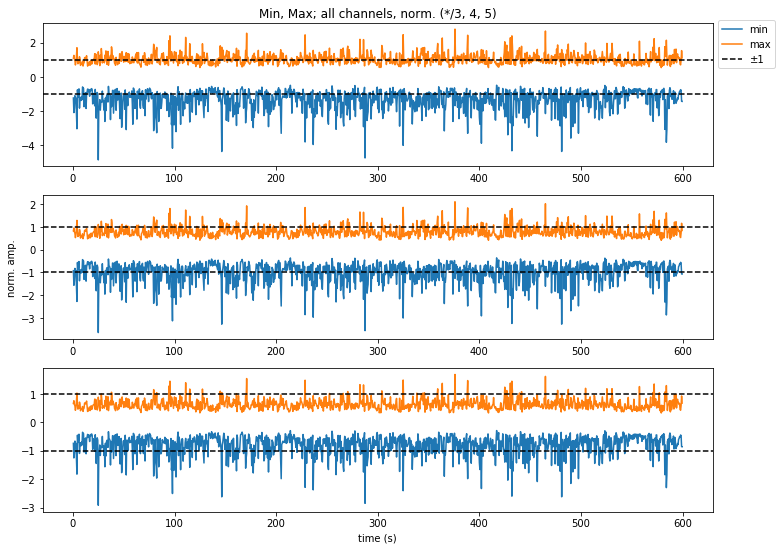

In [7]:
# look @min/max values on 1s windows, 0.5s steps
window_len = 125
step_len = 125
n_window = (n_data-window_len)//step_len
min_max_win = np.zeros((2,n_window))
for w_idx in range(n_window):
    data_idx = w_idx*step_len + np.arange(window_len)
    min_max_win[0,w_idx] = np.min(data_z[:,data_idx].reshape(-1))
    min_max_win[1,w_idx] = np.max(data_z[:,data_idx].reshape(-1))
win_t = 0.5 + np.arange(n_window)/2
f, ax = plt.subplots(3,1,figsize=(12,9))
ax[0].plot(win_t,min_max_win.T/3)
ax[0].axhline(-1,color='black',linestyle='--')
ax[0].axhline(1,color='black',linestyle='--')
ax[1].plot(win_t,min_max_win.T/4)
ax[1].axhline(-1,color='black',linestyle='--')
ax[1].axhline(1,color='black',linestyle='--')
ax[2].plot(win_t,min_max_win.T/5)
ax[2].axhline(-1,color='black',linestyle='--')
ax[2].axhline(1,color='black',linestyle='--')
ax[0].legend(('min','max','±1'),bbox_to_anchor=(1.0, 1.05))
ax[2].set_xlabel('time (s)')
ax[1].set_ylabel('norm. amp.')
ax[0].set_title('Min, Max; all channels, norm. (*/3, 4, 5)')

(56, 150000)


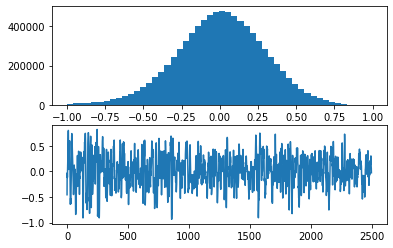

In [8]:
# look at histogram of tanh-norm data
print(data_z.shape)
data_z = data_z/3
data_sig = np.tanh(data_z)
data_sig.shape
f,ax = plt.subplots(2,1)
ax[0].hist(data_sig.reshape(-1),50)
ax[1].plot(data_sig[0,:250*10])

### Assess effects of normalization on data - spectral characterization

In [9]:
# compute mtpsd estimates from normalized data
srate = srate_down
win_t = 8.0
over_t = 4.0
del_f = 0.5 # desired bandwidth (Hz)
bw = int(win_t * del_f /2)

fz, tz, Sz = datafilter.mt_sgram(data_z,srate,win_t,over_t,bw,interp=False,mask=None)
ft, tt, St = datafilter.mt_sgram(data_sig,srate,win_t,over_t,bw,interp=False,mask=None)

In [10]:
# define function for spectrogram plotting; forgive the misnomer
def plot_psd(ax,psd,x,y,clim,cmap='viridis'):
    # create norm from clim
    norm = plt.Normalize(vmin=clim[0],vmax=clim[1])
    # get axes extent from x, y
    extent = (x.min(), x.max(), y.min(), y.max())
    # plot the figure
    im_h = ax.imshow(10*np.log10(psd),extent=extent,norm=norm,origin='bottom')
    # add a colorbar
    cb_h = plt.colorbar(im_h, ax=ax, label='dB', pad=0.01)
    
    return im_h, cb_h

/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


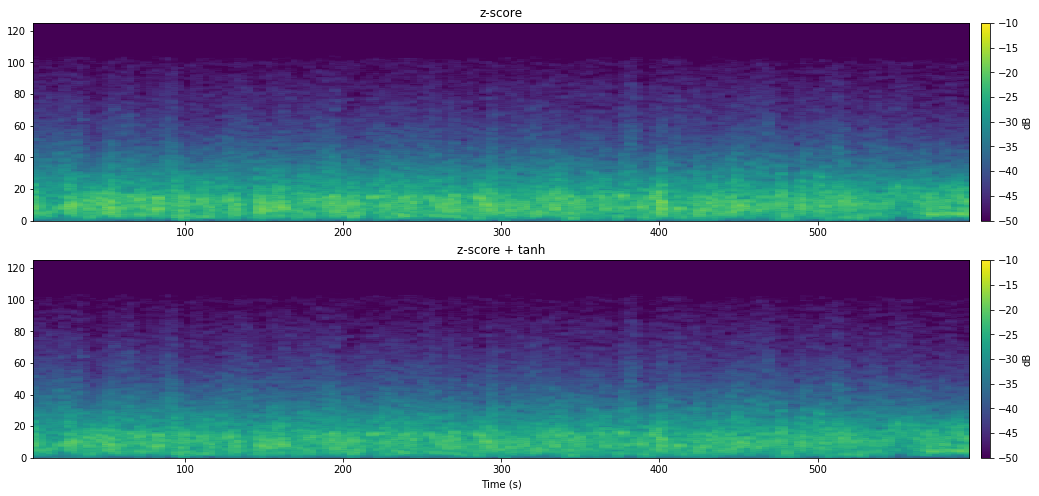

In [11]:
# plot spectrograms
f_psd,ax = plt.subplots(2,1,figsize=(20,8)) 
z_im_h, _ = plot_psd(ax[0],Sz[0,],tz,fz,(-50,-10))
plot_psd(ax[1],St[0,],tt,ft,(-50,-10))
ax[1].set_xlabel('Time (s)')
ax[0].set_title('z-score')
ax[1].set_title('z-score + tanh')
f_psd.show()

Text(0.5, 1.0, 'Spectrum Difference, Log-scale')

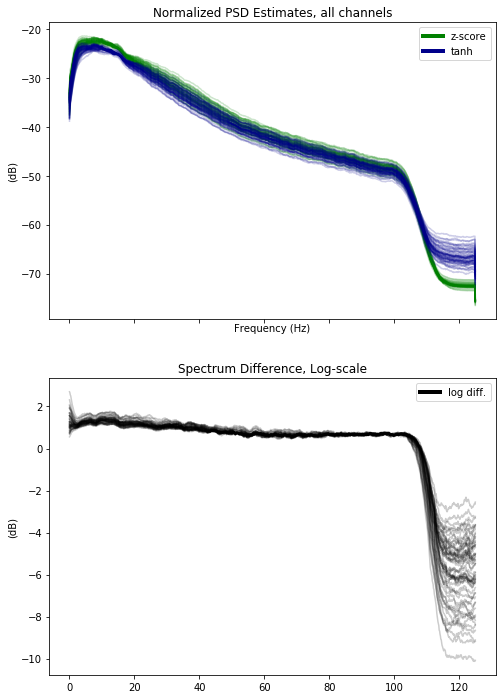

In [12]:
psd_z_mean_db = 10*np.log10(Sz.mean(axis=-1))
psd_t_mean_db = 10*np.log10(St.mean(axis=-1))
psd_diff_db = psd_z_mean_db - psd_t_mean_db

f_log,ax = plt.subplots(2,1,figsize=(8,12),sharex=True)
ax[0].plot(fz,psd_z_mean_db.T,color='green',alpha=0.2)
ax[0].plot(ft,psd_t_mean_db.T,color='darkblue',alpha=0.2,label='tanh')
leg_el_0 = [plt.Line2D([0],[0],color='green',linewidth=4,label='z-score')
           ,plt.Line2D([0],[0],color='darkblue',linewidth=4,label='tanh')]
ax[0].legend(handles=leg_el_0,loc=0)
ax[0].set_ylabel('(dB)')
ax[0].set_title('Normalized PSD Estimates, all channels')
ax[1].plot(fz,psd_diff_db.T,color='k',alpha=0.2)
leg_el_1 = [plt.Line2D([0],[0],color='k',linewidth=4,label='log diff.')]
ax[1].legend(handles=leg_el_1,loc=0)
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('(dB)')
ax[1].set_title('Spectrum Difference, Log-scale')

(125,)


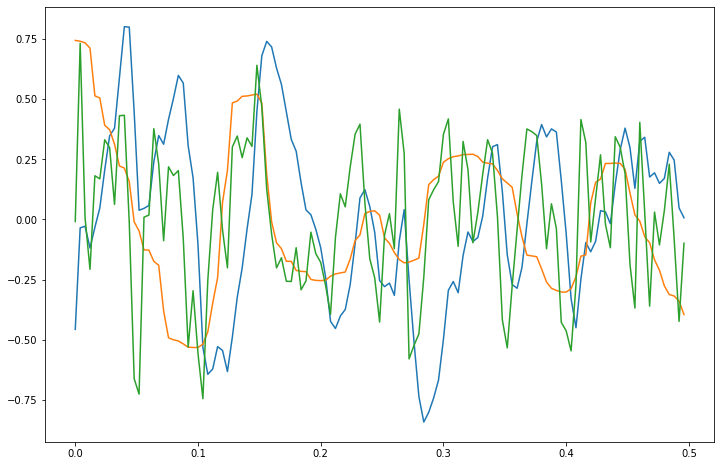

In [61]:
# test the TVD derivative estimator
n_plot = 125
t = np.arange(n_plot)/srate_down
d_data_sig = Tvregdiff.TVRegDiff(data_sig[0,:n_plot].squeeze(), itern=2, alph=10, u0=None, scale='large', ep=1e-6, dx=1/srate_down, plotflag=False)
d_dummy = np.concatenate(([0],np.diff(data_sig[0,:n_plot].squeeze())))
f,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(t,data_sig[0,:n_plot])
ax.plot(t,np.tanh(sp.stats.zscore(d_data_sig)/3))
ax.plot(t,np.tanh(sp.stats.zscore(d_dummy)/3))
print(d_data_sig.shape)